In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from IPython.display import clear_output

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from Local_Library import data_prep, kalman_filter, data_prep_arima, data_prep_svr, arch_volatility_predictor, svr_predictor
from Local_Library import garch_volatility_predictor, LSTM_predictor, arima_predictor
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.svm import SVR

In [3]:
years = 2 
ETF_df = pd.read_csv('ETF_df.csv').iloc[-252*years:,111] # Selecting the latest two years of ETF data to test ML models.
ETF_data = ETF_df.dropna() # Removing missing values.
ETF_returns_df = ETF_data.pct_change() # Estimating % returns.
ETF_returns_data = pd.Series(ETF_returns_df) # Converting ETF data to series format.
window = 22

## ARCH Model

In [4]:
prep_data = data_prep(ETF_returns_data, 'Actual_Return', window, dropna=True, scale=True) # Preparing data structures for ARCH model.
prep_data['X_train_var_arch'] = prep_data['X_train'].apply(lambda x: arch_volatility_predictor(x)) # Applying ARCH model on each row of the prepared data.

In [5]:
prep_data['X_train_var_arch_filtered'] = kalman_filter(prep_data['X_train_var_arch'].values) # Applying kalman filter to de-noise the data.
X_train_var_adjusted = prep_data['X_train_var'][1:] # Adjusting for prediction shift.
X_train_var_arch_filtered_adjusted = prep_data['X_train_var_arch_filtered'][:-1] # Adjusting for prediction shift.
prep_data_adjusted = pd.DataFrame(list(zip(
    X_train_var_adjusted, X_train_var_arch_filtered_adjusted)), columns=['X_train_var_adjusted', 
                                                                         'X_train_var_arch_filtered_adjusted']) # Storing required information in a data frame.
print('ARCH RMSE:', np.sqrt(mean_squared_error(prep_data_adjusted[['X_train_var_adjusted']], 
                                               prep_data_adjusted[['X_train_var_arch_filtered_adjusted']]))) # Calculating and printing ARCH mse.

ARCH RMSE: 0.21754894029590177


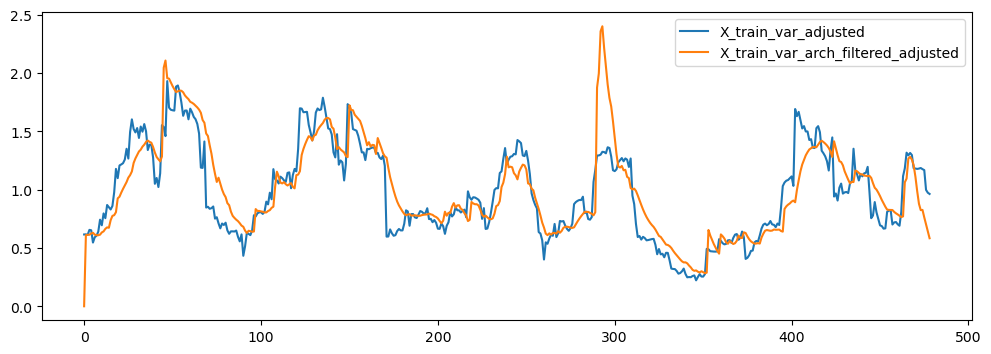

In [6]:
prep_data_adjusted[['X_train_var_adjusted','X_train_var_arch_filtered_adjusted']].plot(figsize=(12,4)); # Printing real and estimated volatility.


## GARCH

In [7]:
prep_data_garch = data_prep(ETF_returns_data, 'Actual_Return', window, dropna=True, scale=True) # Preparing data structures for GARCH model.
prep_data_garch['X_train_var_garch'] = prep_data_garch['X_train'].apply(lambda x: garch_volatility_predictor(x)) # Applying GARCH model on each row of the prepared data.


In [8]:
prep_data_garch['X_train_var_garch_filtered'] = kalman_filter(prep_data_garch['X_train_var_garch'].values) # Applying kalman filter to de-noise the data.
X_train_var_adjusted = prep_data_garch['X_train_var'][1:] # Adjusting for prediction shift.
X_train_var_arch_filtered_adjusted = prep_data_garch['X_train_var_garch_filtered'][:-1] # Adjusting for prediction shift.
prep_data_adjusted = pd.DataFrame(list(zip(
    X_train_var_adjusted, X_train_var_arch_filtered_adjusted)), columns=['X_train_var_adjusted', 
                                                                         'X_train_var_garch_filtered_adjusted']) # Storing required information in a data frame.
print('GARCH RMSE:', np.sqrt(mean_squared_error(prep_data_adjusted[['X_train_var_adjusted']], 
                                               prep_data_adjusted[['X_train_var_garch_filtered_adjusted']]))) # Calculating and printing GARCH mse.


GARCH RMSE: 0.1679496465801336


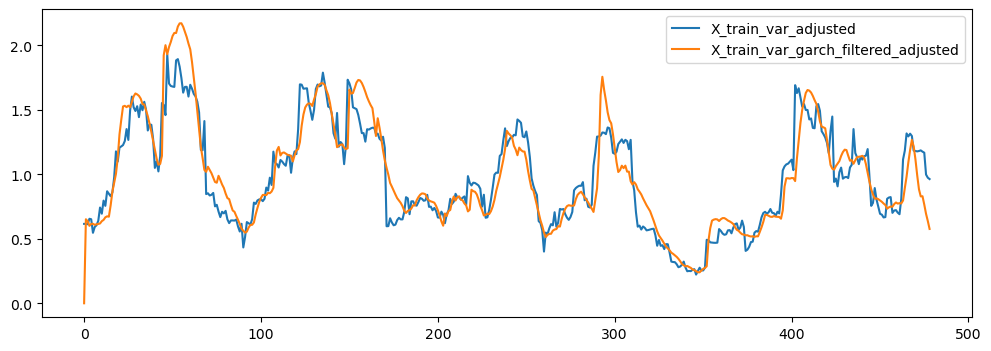

In [9]:
prep_data_adjusted[['X_train_var_adjusted','X_train_var_garch_filtered_adjusted']].plot(figsize=(12,4)); # Printing real and estimated volatility.


## LSTM

In [10]:
data_df_lstm  = data_prep_arima(ETF_returns_data, 'Actual_Return', 
                                'Actual_Variance', window, dropna=True, scale=True) # Preparing data structures for LSTM model.
input_shape = (window, 1) # Shape of the input data based on volatility window length.
# Instantiating the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

data_df_lstm["Predicted_Variance"] = data_df_lstm[[
    'X_train','y_train','X_test']].apply(lambda x: LSTM_predictor(
    lstm_model, x['X_train'],x['y_train'],x['X_test'])[0][0], axis=1) # Applying LSTM model on each row of the prepared data.


In [11]:
print('LSTM RMSE:', np.sqrt(mean_squared_error(data_df_lstm[['y_test']], 
                                               data_df_lstm[['Predicted_Variance']]))) # Calculating and printing LSTM mse.


LSTM RMSE: 0.41299845042129296


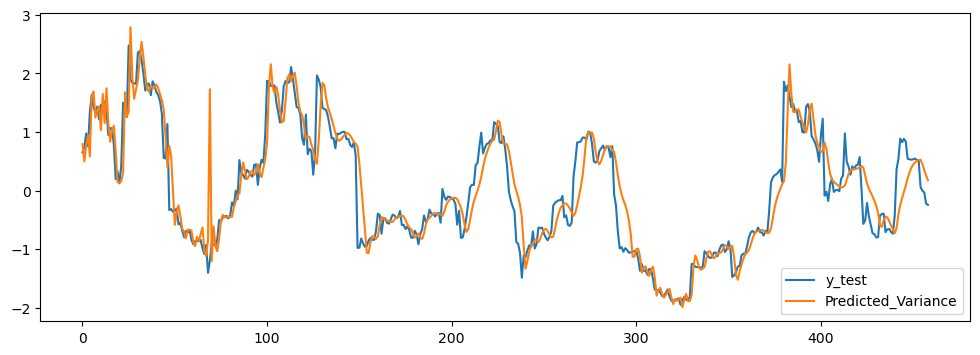

In [12]:
data_df_lstm[['y_test','Predicted_Variance']].plot(figsize=(12,4)); # Printing real and estimated volatility.

## SVR

In [13]:
window = 22
prep_data_svr  = data_prep_svr(ETF_returns_data, 'Actual_Return', 
                               'Actual_Variance', window, dropna=True, scale=True) # Preparing data structures for SVR model.
# Instantiating the SVR model
svr_model = SVR(kernel='rbf', C=1000, gamma=0.1)

prep_data_svr["Predicted_Variance"] = prep_data_svr[[
    'X_train','y_train','X_test']].apply(lambda x: svr_predictor(
    svr_model, x['X_train'],x['y_train'],x['X_test'])[0], axis=1) # Applying SVR model on each row of the prepared data.


In [14]:
y_test_adjusted = [x[0] for x in prep_data_svr.y_test.values] # Extracting test data which is used for SVR model analysis.
y_predicted = prep_data_svr['Predicted_Variance'] # Extracting predicted data which is used for SVR model analysis.

prep_data_svr_adjusted = pd.DataFrame(list(zip(
    y_test_adjusted, y_predicted)), columns=['y_test_adjusted','y_predicted']) # Storing required information in a data frame.
print('SVR RMSE:', np.sqrt(mean_squared_error(prep_data_svr_adjusted[['y_test_adjusted']], 
                                               prep_data_svr_adjusted[['y_predicted']]))) # Calculating and printing LSTM mse.


SVR RMSE: 0.2085473911426038


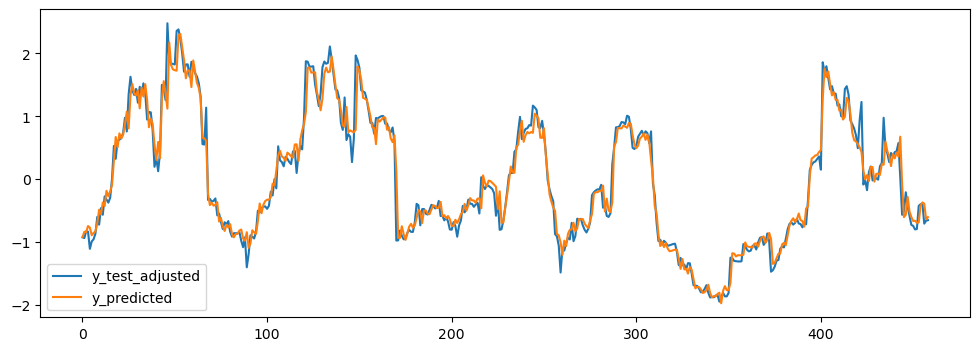

In [15]:
prep_data_svr_adjusted[['y_test_adjusted',"y_predicted"]].plot(figsize=(12,4)); # Printing real and estimated volatility.

## ARIMA

In [16]:
window = 22
prep_data_arima = data_prep_arima(ETF_returns_data, 'Actual_Return', 
                                  'Actual_Variance', window, dropna=True, scale=True) # Preparing data structures for ARIMA model.

prep_data_arima["Predicted_Variance"] = prep_data_arima[
    'X_train'].apply(lambda x: arima_predictor(x)[0]) # Applying ARIMA model on each row of the prepared data.

clear_output()


In [17]:
print('ARIMA RMSE:', np.sqrt(mean_squared_error(prep_data_arima[['y_test']],
                                                                prep_data_arima[['Predicted_Variance']]))) # Calculating and printing ARIMA mse.


ARIMA RMSE: 0.41267708541770604


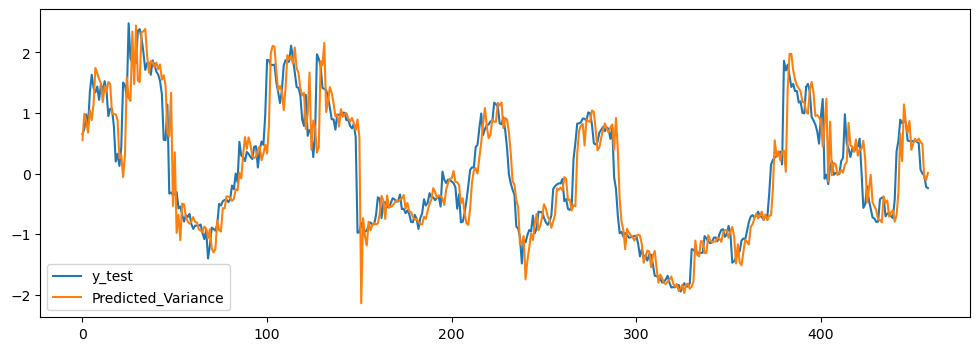

In [18]:
prep_data_arima[['y_test','Predicted_Variance']].plot(figsize=(12,4)); # Printing real and estimated volatility.